Some issues with swarmpyfac at present:

1. There's some problem with the latest package on PyPI:
   ```
   (py37) ash@yog:~$ pip install swarmpyfac==0.2.1
    ERROR: Could not find a version that satisfies the requirement swarmpyfac==0.2.1 (from versions: 0.2.1.linux-x86_64, 0.1.1, 0.1.2)
    ERROR: No matching distribution found for swarmpyfac==0.2.1
   ```
2. Installing the latest master branch (`pip install git+https://github.com/Swarm-DISC/SwarmPyFAC.git`), I get the below error when running the example
3. The top-level interface is a bit confusing and (I think) there is unnecessary complication in the layers between fetching the data and implementing the algorithm

I have built a more minimal example below, using `swarmpyfac.fac.single_sat_fac` to just apply the algorithm, and where the data loading into an `xarray.Dataset` is handled by `viresclient`. The idea here is that swarmpyfac shouldn't (necessarily) have to know how to handle the underlying CDF file, and that we can pass around this more structured `xarray.Dataset` rather than tuples or dicts. The problem is that this requires learning xarray, which is hard! but I think will pay off in the long term. To start with though, you can really just treat it like a complex dictionary, accessing numpy arrays like: `ds["Latitude"].data`. Appending data to it is more complex though, as it requires understanding of "coordinates" and "dimensions" in xarray.

I have only covered the case where we fetch data from vires rather than using local data. If a local CDF is to be used, I think it can be loaded in an identical way using `viresclient._data_handling.make_xarray_Dataset_from_cdf` with some additional steps... but should avoid using that as it is a private function within viresclient (though I could change that)

In [1]:
import swarmpyfac as fc
import datetime as date
start = date.datetime(2016, 1, 1)
end = date.datetime(2016, 1, 2)
output, input_data = fc.fac_from_file(start=start, end=end)
time, position, __, fac, *___ = output

TypeError: request_data() got an unexpected keyword argument 'use_pop'

# More minimal working example

This is essentially a two-step procedure:

1. `request_data()`
    - Fetch data from VirES as a xarray.Dataset
2. 1. `get_input_data_from_ds()`
        - Extract the numpy arrays that the algorithm function expects to work on
   2. `append_fac()`
        - Passes the numpy arrays to the algorithm function (`single_sat_fac`) - at this point other algorithms or configuration could be supplied
        - Append new FAC columns to the dataset

... and what you get out is a dataset with the original data plus the newly determined FAC estimates

Further below I wrap these in a higher level interface `fetch_swarm_fac()`

I imagine these in a namespace like:
```
├── swarmpyfac
│   ├── fetch_swarm_fac
│   ├── append_fac
│   ├── algorithms
│       ├── single_sat_fac
│       ├── ... other algo's
│   ├── utils
```

so that someone may:
- `from swarmpyfac.algorithms import single_sat_fac` and apply that to whatever independent data
- or `from swarmpyfac import append_fac` to apply to a dataset they are already working with which may have been fetched from VirES already (but must conform to some expectations of the dataset content)
- or just `from swarmpyfac import fetch_swarm_fac` to get it all on-the-fly

In [2]:
import numpy as np
import pandas as pd
from viresclient import SwarmRequest
import matplotlib.pyplot as plt
%matplotlib inline

from swarmpyfac.fac import single_sat_fac

### 1. Fetch data from VirES

It takes 35 seconds to process one day. The bottleneck is in the MLI and MMA models.

The processing progress bar waits mostly at 0% - can the progress reporting from the server be improved?

In [3]:
def request_data(
        start=date.datetime(2016, 1, 1),
        end=date.datetime(2016, 1, 2),
        spacecraft='A',
        filters=[{'parameter': 'Latitude',
                  'minimum': -90.,
                  'maximum': 90.}],
        product_options={'auxiliaries': ['QDLat', 'QDLon', 'OrbitNumber']},
        sampling_step='PT1S',
        # this lets us fetch the full (summed) model from the server directly
        # This approach simplifies the "data" we then deal with afterwards
        # But is this okay? Do we ever need access to the model constituents?
        model='Model = "MCO_SHA_2C" + "MLI_SHA_2C" + "MMA_SHA_2C-Primary" + "MMA_SHA_2C-Secondary"',
#         model="MCO_SHA_2C",
        measurements=['F', 'B_NEC'],
        # vires credentials - if none supplied, defaults set by ~/.viresclient.ini are used
        url=None, token=None, username=None, password=None,):
    request = SwarmRequest(url, token, username, password)
    collection = f'SW_OPER_MAG{spacecraft}_LR_1B'
    request.set_collection(collection)
    request.set_products(measurements=measurements, models=[model],
                         sampling_step=sampling_step, **product_options)
    for filter in filters:
        request.set_range_filter(**filter)
    data = request.get_between(start_time=start, end_time=end)
    ds = data.as_xarray()
    return ds

ds = request_data()
ds

[1/1] Processing:  100%|██████████|  [ Elapsed: 00:36, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:03, Remaining: 00:00 ] (10.116MB)


<xarray.Dataset>
Dimensions:      (B_NEC_Model_dim1: 3, B_NEC_dim1: 3, Timestamp: 86400)
Coordinates:
  * Timestamp    (Timestamp) datetime64[ns] 2016-01-01 ... 2016-01-01T23:59:59
Dimensions without coordinates: B_NEC_Model_dim1, B_NEC_dim1
Data variables:
    Spacecraft   (Timestamp) <U1 'A' 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A' 'A'
    Latitude     (Timestamp) float64 -72.5 -72.56 -72.63 ... 31.55 31.61 31.67
    Longitude    (Timestamp) float64 92.79 92.82 92.85 ... -95.37 -95.37 -95.37
    Radius       (Timestamp) float64 6.834e+06 6.834e+06 ... 6.823e+06 6.823e+06
    F            (Timestamp) float64 4.694e+04 4.693e+04 ... 3.886e+04 3.889e+04
    F_Model      (Timestamp) float64 4.686e+04 4.685e+04 ... 3.886e+04 3.889e+04
    B_NEC        (Timestamp, B_NEC_dim1) float64 -1.581e+03 ... 3.397e+04
    B_NEC_Model  (Timestamp, B_NEC_Model_dim1) float64 -1.621e+03 ... 3.397e+04
    QDLat        (Timestamp) float64 -81.1 -81.13 -81.16 ... 41.26 41.32 41.39
    QDLon        (Timestamp) float64 103.6 103.3 102.9 ... -24.83 -24.83 -24.83
    OrbitNumber  (Timestamp) int32 11803 11803 11803 11803 ... 11819 11819 11819
Attributes:
    Sources:         ['SW_OPER_AUXAORBCNT_20131122T000000_20191129T000000_000...
    MagneticModels:  ["Model = MCO_SHA_2C(max_degree=18,min_degree=1) + MLI_S...
    RangeFilters:    ['Latitude:-90,90']

#### NB: I just noticed a bug here:
the `B_NEC` and `B_NEC_Model` data variables should share the same dimension name (so that `ds['B_NEC'] - ds['B_NEC_Model']` works as expected, etc.)

### 2. Define functions to interface between a dataset and the algorithms to apply

In [4]:
def get_input_data_from_ds(ds):
    """Extract the "input_data" required from the dataset"""
    # convert time to unix time seconds
    ## if on a dataframe, df:
    ## time = np.array(df.index.astype(np.int64) / 10**9)
    # on xarray.Dataset:
    time = ds['Timestamp'].data.astype(np.int64) / 10**9
    theta = ds['Latitude'].data
    phi = ds['Longitude'].data
    r = ds['Radius'].data
    # equivalent to swarmpyfac.utils.pack_3d:
    positions = np.stack((theta, phi, r), axis=1)
    B_model = ds['B_NEC_Model'].data
    B_res = ds['B_NEC'].data - B_model
    return {'time': time, 'positions':positions,
            'B_res': B_res, 'B_model': B_model}

def append_fac(ds=None, method='single_sat'):
    """Append FAC calculations to a dataset"""
    if method == 'single_sat':
        input_data = get_input_data_from_ds(ds)
        output = single_sat_fac(**input_data)
        # outputs like these should probably be turned into a dict so that they can be identified
        irc = output[2]
        fac = output[3]
        time = output[0]
    else:
        raise NotImplementedError
    # Append the new data to the dataset
    # https://xarray.pydata.org/en/stable/data-structures.html#dictionary-like-methods
    # Note that there must now be a new offset time coordinate
    ds.coords['Timestamp_2'] = pd.to_datetime(time, unit='s')
    ds[f'FAC_{method}'] = (('Timestamp_2',), fac)
    ds[f'IRC_{method}'] = (('Timestamp_2',), irc)
    return ds

### 3. Use the above functions to append the FAC values to our dataset

Note that we now have two time coordinates, one for the input data (`Timestamp`), and one for the FAC (`Timestamp_2`). There might be a cleaner way of handling this... a couple of options:
1. Interpolate the data to one or the other time series (not safe in general)
2. Make a new time coordinate which is the union of the two, where the data contain nan's where they are not sampled (i.e. every other point)

In [5]:
ds = append_fac(ds, method='single_sat')
ds

<xarray.Dataset>
Dimensions:         (B_NEC_Model_dim1: 3, B_NEC_dim1: 3, Timestamp: 86400, Timestamp_2: 86399)
Coordinates:
  * Timestamp       (Timestamp) datetime64[ns] 2016-01-01 ... 2016-01-01T23:59:59
  * Timestamp_2     (Timestamp_2) datetime64[ns] 2016-01-01T00:00:00.500000 ... 2016-01-01T23:59:58.500000
Dimensions without coordinates: B_NEC_Model_dim1, B_NEC_dim1
Data variables:
    Spacecraft      (Timestamp) <U1 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A' 'A'
    Latitude        (Timestamp) float64 -72.5 -72.56 -72.63 ... 31.61 31.67
    Longitude       (Timestamp) float64 92.79 92.82 92.85 ... -95.37 -95.37
    Radius          (Timestamp) float64 6.834e+06 6.834e+06 ... 6.823e+06
    F               (Timestamp) float64 4.694e+04 4.693e+04 ... 3.889e+04
    F_Model         (Timestamp) float64 4.686e+04 4.685e+04 ... 3.889e+04
    B_NEC           (Timestamp, B_NEC_dim1) float64 -1.581e+03 ... 3.397e+04
    B_NEC_Model     (Timestamp, B_NEC_Model_dim1) float64 -1.621e+03 ... 3.397e+04
    QDLat           (Timestamp) float64 -81.1 -81.13 -81.16 ... 41.32 41.39
    QDLon           (Timestamp) float64 103.6 103.3 102.9 ... -24.83 -24.83
    OrbitNumber     (Timestamp) int32 11803 11803 11803 ... 11819 11819 11819
    FAC_single_sat  (Timestamp_2) float64 -0.1351 -0.04231 ... -0.01048
    IRC_single_sat  (Timestamp_2) float64 -0.1317 -0.04125 ... 0.005339 0.009156
Attributes:
    Sources:         ['SW_OPER_AUXAORBCNT_20131122T000000_20191129T000000_000...
    MagneticModels:  ["Model = MCO_SHA_2C(max_degree=18,min_degree=1) + MLI_S...
    RangeFilters:    ['Latitude:-90,90']

### A couple of options for plotting from dataset

/home/ash/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


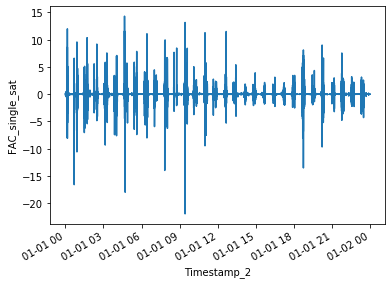

In [6]:
ds['FAC_single_sat'].plot()

Note that I fetched the `OrbitNumber` from VirES so that I can apply orbit-by-orbit colouring. And we have to adjust the length of `QDLat` and `OrbitNumber` to match the new FAC_single_sat 

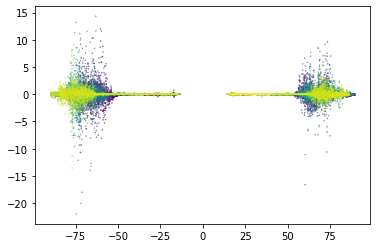

In [7]:
plt.scatter(ds['QDLat'][1:], ds['FAC_single_sat'], c=ds['OrbitNumber'][1:], s=0.1)

### 4. Combine the above steps in a higher level interface

This is the kind of interface I would like to use if I were just wanting to get the FAC "measurements" using such-and-such a method, or maybe wanting to compare the results from using different algorithms or setting.

A couple of possible extensions to this:
1. Optional output as just a dict so that users don't have to be exposed to xarray if they don't want to be
2. Add possibility to pass through more options, to include more data (e.g. `vires_kwargs` or `data_kwargs`) or algorithm configuration (e.g. `algo_kwargs`)

In [12]:
def fetch_swarm_fac(
        start=date.datetime(2016, 1, 1),
        end=date.datetime(2016, 1, 2),
        spacecraft='A',
        geomagnetic_model_series='CHAOS',
        fac_method='single_sat'):
    if geomagnetic_model_series == 'CHAOS':
        model = 'Model = "CHAOS-Core" + "CHAOS-Static" + "CHAOS-MMA-Primary" + "CHAOS-MMA-Secondary"'
    elif geomagnetic_model_series == 'CI':
        model = 'Model = "MCO_SHA_2C" + "MLI_SHA_2C" + "MMA_SHA_2C-Primary" + "MMA_SHA_2C-Secondary"'
    else:
        raise NotImplementedError
    ds = request_data(start=start, end=end, spacecraft=spacecraft, model=model)
    ds = append_fac(ds, method='single_sat')
    return ds

### Compare using the CI models and CHAOS models (an example "end user" workflow)

Note that the bottleneck with the CHAOS models is even more - this is because of the different structure of the MMA parts

In [13]:
ds_chaos = fetch_swarm_fac(
    '2016-01-01', '2016-01-02', spacecraft='A',
    geomagnetic_model_series='CHAOS', fac_method='single_sat')
ds_chaos

[1/1] Processing:  100%|██████████|  [ Elapsed: 01:11, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:07, Remaining: 00:00 ] (10.116MB)


<xarray.Dataset>
Dimensions:         (B_NEC_Model_dim1: 3, B_NEC_dim1: 3, Timestamp: 86400, Timestamp_2: 86399)
Coordinates:
  * Timestamp       (Timestamp) datetime64[ns] 2016-01-01 ... 2016-01-01T23:59:59
  * Timestamp_2     (Timestamp_2) datetime64[ns] 2016-01-01T00:00:00.500000 ... 2016-01-01T23:59:58.500000
Dimensions without coordinates: B_NEC_Model_dim1, B_NEC_dim1
Data variables:
    Spacecraft      (Timestamp) <U1 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A' 'A'
    Latitude        (Timestamp) float64 -72.5 -72.56 -72.63 ... 31.61 31.67
    Longitude       (Timestamp) float64 92.79 92.82 92.85 ... -95.37 -95.37
    Radius          (Timestamp) float64 6.834e+06 6.834e+06 ... 6.823e+06
    F               (Timestamp) float64 4.694e+04 4.693e+04 ... 3.889e+04
    F_Model         (Timestamp) float64 4.689e+04 4.689e+04 ... 3.889e+04
    B_NEC           (Timestamp, B_NEC_dim1) float64 -1.581e+03 ... 3.397e+04
    B_NEC_Model     (Timestamp, B_NEC_Model_dim1) float64 -1.602e+03 ... 3.397e+04
    QDLat           (Timestamp) float64 -81.1 -81.13 -81.16 ... 41.32 41.39
    QDLon           (Timestamp) float64 103.6 103.3 102.9 ... -24.83 -24.83
    OrbitNumber     (Timestamp) int32 11803 11803 11803 ... 11819 11819 11819
    FAC_single_sat  (Timestamp_2) float64 -0.1332 -0.04045 ... -0.009421
    IRC_single_sat  (Timestamp_2) float64 -0.1299 -0.03943 ... 0.004412 0.008228
Attributes:
    Sources:         ['CHAOS-7_static.shc', 'SW_OPER_AUXAORBCNT_20131122T0000...
    MagneticModels:  ["Model = 'CHAOS-Core'(max_degree=20,min_degree=1) + 'CH...
    RangeFilters:    ['Latitude:-90,90']

In [14]:
ds_ci = evaluate_swarm_fac(
    '2016-01-01', '2016-01-02', spacecraft='A',
    geomagnetic_model_series='CI', fac_method='single_sat')
ds_ci

[1/1] Processing:  100%|██████████|  [ Elapsed: 00:36, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:03, Remaining: 00:00 ] (10.116MB)


<xarray.Dataset>
Dimensions:         (B_NEC_Model_dim1: 3, B_NEC_dim1: 3, Timestamp: 86400, Timestamp_2: 86399)
Coordinates:
  * Timestamp       (Timestamp) datetime64[ns] 2016-01-01 ... 2016-01-01T23:59:59
  * Timestamp_2     (Timestamp_2) datetime64[ns] 2016-01-01T00:00:00.500000 ... 2016-01-01T23:59:58.500000
Dimensions without coordinates: B_NEC_Model_dim1, B_NEC_dim1
Data variables:
    Spacecraft      (Timestamp) <U1 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A' 'A'
    Latitude        (Timestamp) float64 -72.5 -72.56 -72.63 ... 31.61 31.67
    Longitude       (Timestamp) float64 92.79 92.82 92.85 ... -95.37 -95.37
    Radius          (Timestamp) float64 6.834e+06 6.834e+06 ... 6.823e+06
    F               (Timestamp) float64 4.694e+04 4.693e+04 ... 3.889e+04
    F_Model         (Timestamp) float64 4.686e+04 4.685e+04 ... 3.889e+04
    B_NEC           (Timestamp, B_NEC_dim1) float64 -1.581e+03 ... 3.397e+04
    B_NEC_Model     (Timestamp, B_NEC_Model_dim1) float64 -1.621e+03 ... 3.397e+04
    QDLat           (Timestamp) float64 -81.1 -81.13 -81.16 ... 41.32 41.39
    QDLon           (Timestamp) float64 103.6 103.3 102.9 ... -24.83 -24.83
    OrbitNumber     (Timestamp) int32 11803 11803 11803 ... 11819 11819 11819
    FAC_single_sat  (Timestamp_2) float64 -0.1351 -0.04231 ... -0.01048
    IRC_single_sat  (Timestamp_2) float64 -0.1317 -0.04125 ... 0.005339 0.009156
Attributes:
    Sources:         ['SW_OPER_AUXAORBCNT_20131122T000000_20191129T000000_000...
    MagneticModels:  ["Model = MCO_SHA_2C(max_degree=18,min_degree=1) + MLI_S...
    RangeFilters:    ['Latitude:-90,90']

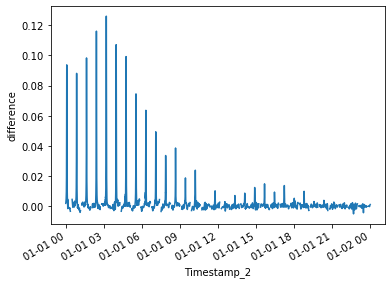

In [15]:
fig, ax = plt.subplots(1, 1)
(ds_chaos['FAC_single_sat'] - ds_ci['FAC_single_sat']).plot(ax=ax)
ax.set_ylabel('difference');